# Klasifikacija teksta

Osim u obradi slika, konvolutivne neuronske mreže mogu se koristiti i u obradi teksta. Sledeći primer se odnosi na jednu takvu primenu u kojoj se 1D konvolutivne mreže koriste za klasifikaciju filmskih pregleda na pozitivne i negativne. 

 <img src='assets/1CovNets_for_NLP.png'>

U osnovi ovog pristupa je sledeća ideja. Pojedinačne reči teksta je potrebno prikazati kao vektore, a zatim konvolucijskim prozorima posmatrati njihove okoline. Na taj način može da se nauči o kontekstu pojave reči i njenoj semantici. Mi smo do sada videli već neke načine za predstavljanje reči, na primer, koristili smo Tf-Idf reprezentacije. U ovom primeru ćemo pustiti da sama mapira reči u vektore odgovarajućih dužina. Ta pojava se zove ugnježdavanje (engl. embedding).  

Prvo ćemo učitati sve neophodne biblioteke.

In [33]:
from keras.datasets import imdb

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Conv1D, MaxPool1D, GlobalMaxPool1D
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.optimizers import SGD, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import backend as K
from keras.preprocessing import sequence

In [3]:
from matplotlib import pyplot as plt
import numpy as np
np.random.seed(7)

## Korak 1: Učitavanje skupa podataka

Za učitavanje podataka iskoristićemo podršku Keras biblioteke. Skup podataka sa kojim radimo se zove `imdb`. Prilikom učitavanja ovog skupa potrebno je da parametrom `max_features` navedemo koliko ćemo najviše reči posmatrati u kolekciji pregleda. Na ovaj način će se zadržati samo one reči pregleda koje pripadaju skupu od `max_features` najfrekventnijih reči.

In [4]:
max_features = 2000 

In [5]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)

In [6]:
X_train.shape

(25000,)

In [7]:
X_test.shape

(25000,)

In [8]:
type(X_train[0])

list

In [9]:
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 1920, 2, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


Dužina pročitane instance je:

In [10]:
len(X_train[0])

218

Pojedinačne reči su sadržane u rečniku koji se može dobiti pozivom funkcije `get_word_index`.

In [11]:
imdb.get_word_index()

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

Sam sadržaj rečenice možemo dobiti isčitavanjem rečnika i indeksa reči.

In [12]:
inverted_word_index = {index: word for word, index in imdb.get_word_index().items()}

In [13]:
review = [inverted_word_index[i] for i in X_train[0]]

In [14]:
print(" ".join(review))

the as you with out themselves powerful lets loves their becomes and had and of lot from anyone to have after out atmosphere never more room and it so heart shows to years of every never going and help moments or of every and visual movie except her was several of enough more with is now and film as you of mine and unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but and to story wonderful that in seeing in character to of and and with heart had and they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other and in of seen over and for anyone of and br and to whether from than out themselves history he name half some br of and odd was two most of mean for 1 any an and she he should is thought and but of script you not while history he heart to real at and but when from one bit then have two of script their with her nobody most that wit

## Korak 2: Priprema podataka

Da bismo sve preglede mogli da obrađujemo na isti način, moramo usaglasiti i njihove dužine. Mi ćemo se ograničiti na prvih 400 reči pregleda. Ukoliko je tekst duži od 200 reči, doći će do odsecanja sadržaja. Ukoliko je tekst kraći od 200 reči, dopunićemo ga nulama. Funkcija koja ima ovo ponašanje i koju ćemo iskoristiti u radu je `pad_sequence` koja pripada skupu `keras.preprocessing`  funkcija za pripremu sekvencijalnih podataka.

In [15]:
max_len = 400

In [16]:
X_train = sequence.pad_sequences(X_train, maxlen = max_len)

In [17]:
X_train.shape

(25000, 400)

In [18]:
X_test = sequence.pad_sequences(X_test, maxlen = max_len)

In [19]:
X_test.shape

(25000, 400)

U skupu ciljnih promenljivih imamo binarne vrednosti 0 i 1 koje redom predstavljuju negativne tj. pozitivno ocenjene preglede.

In [20]:
np.unique(y_train)

array([0, 1])

Broj pozitivnih i broj negativnih pregleda je jednak.

In [21]:
np.bincount(y_train)

array([12500, 12500])

## Korak 3: Pravljenje modela

Na početku naše mreže naći će se `Embedding` sloj. Ovaj sloj svakoj reči treba da pridruži reprezentaciju dužine 64. Prvi argument predstavlja veličinu vokabulara, drugi željenu dužinu ugnježdenih reprezentacija i treći maksimalnu dužinu pojedinačnih sekvenci. <img src='assets/embeddings.png'>



U ostatku mreže će se smenjivati 1D konvolutivni i 1D agregacioni slojevi uz izmenu da su korišćeni kerneli jednodimenzioni.  <img src='assets/1D_convolution.png'>

Na kraju mreže će se naći jedan gusti sloj sa jednom izlaznom jedinicom. 

In [22]:
model = Sequential() 
model.add(Embedding(max_features, 128, input_length=max_len))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPool1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPool1D(5))
model.add(GlobalMaxPool1D())
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


Kao funkciju greške koristićemo binarnu unakrsnu entropiju, a kao optimizator Adam. 

In [23]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
# callbacks = [TensorBoard(log_dir='kerasboard_live', histogram_freq=1, embeddings_freq=1)]
# model.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.2, callbacks=callbacks)

Mrežu ćemo trenirati u 10 epoha, koristeći paketiće veličine 128 instanci. Uspešnost treniranja pratićemo na validacionom skupu veličine 20% ukupnog skupa podataka. Treniranje će malo potrajati.

In [25]:
epochs = 10
batch_size = 128

In [26]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 68s 3ms/step - loss: 0.6919 - accuracy: 0.5469 - val_loss: 0.6903 - val_accuracy: 0.5670
Epoch 2/10
20000/20000 [==============================] - 60s 3ms/step - loss: 0.6845 - accuracy: 0.6402 - val_loss: 0.6786 - val_accuracy: 0.6572
Epoch 3/10
20000/20000 [==============================] - 56s 3ms/step - loss: 0.6532 - accuracy: 0.7028 - val_loss: 0.6122 - val_accuracy: 0.7296
Epoch 4/10
20000/20000 [==============================] - 68s 3ms/step - loss: 0.5304 - accuracy: 0.7845 - val_loss: 0.4528 - val_accuracy: 0.8124
Epoch 5/10
20000/20000 [==============================] - 63s 3ms/step - loss: 0.4009 - accuracy: 0.8317 - val_loss: 0.3843 - val_accuracy: 0.8360
Epoch 6/10
20000/20000 [==============================] - 59s 3ms/step - loss: 0.3468 - ac

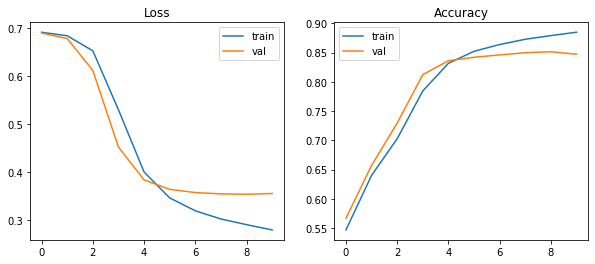

In [27]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(0, epochs), history.history['loss'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label='val')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(0, epochs), history.history['accuracy'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label='val')
plt.legend(loc='best')

Sa ovih grafikona možemo primetiti da se posle četvrte epohe model preprilagođava podacima.

## Korak 4: Evaluacija modela

Mrežu ćemo evaluirati na test skupu.

In [28]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.35513463399887085
Test accuracy: 0.8434000015258789


S obzirom da smo u učenju koristili svega 10000 reči ima smisla probati kako se model ponaša ukoliko se radi sa većim vokabularom. Takođe, ima smisla probati i sa nešto drugačijim ugnježdenim reprezentacijama, na primer, nešto kraćim. 

## Korak 5: Čuvanje modela

Čuvanje Keras modela obuhvata čuvanje informacija o arhitekturi, parametrima, konfiguraciju treniranja i stanja optimizatora tako da se nesmetano može nastaviti sa radom. Modeli se čuvaju u HDF5 formatu koji se koristi za čuvanje velikih količina numeričkih podataka. Za izdvajanje informacija iz ovakvih datoteka možemo koristiti funkcionalnosti biblioteke h5py. Nju možemo instalirati komandom `conda install -c anaconda h5py` u skladu sa [zvaničnim smernicama](https://anaconda.org/anaconda/h5py). Više o samoj biblioteci može se pronaći i na [zvaničnoj stranici](https://www.h5py.org/). 

Mi ćemo u radu koristiti Keras podršku dostupnu kroz `load_model` funkcionalnosti. Funkcijom `save` se čuva model, a funkcijom `load_model` učitava postojeći. 

In [29]:
from keras.models import load_model

In [30]:
model.save('imdb_classifier.h5')

In [31]:
revived_model = load_model('imdb_classifier.h5')

In [32]:
revived_model.get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'Embedding',
   'config': {'name': 'embedding_1',
    'trainable': True,
    'batch_input_shape': (None, 400),
    'dtype': 'float32',
    'input_dim': 2000,
    'output_dim': 128,
    'embeddings_initializer': {'class_name': 'RandomUniform',
     'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
    'embeddings_regularizer': None,
    'activity_regularizer': None,
    'embeddings_constraint': None,
    'mask_zero': False,
    'input_length': 400}},
  {'class_name': 'Conv1D',
   'config': {'name': 'conv1d_1',
    'trainable': True,
    'dtype': 'float32',
    'filters': 32,
    'kernel_size': (7,),
    'strides': (1,),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1,),
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'b